In [47]:
import numpy as np
import pandas as pd
import scipy
from functools import reduce
import seaborn as sns
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline


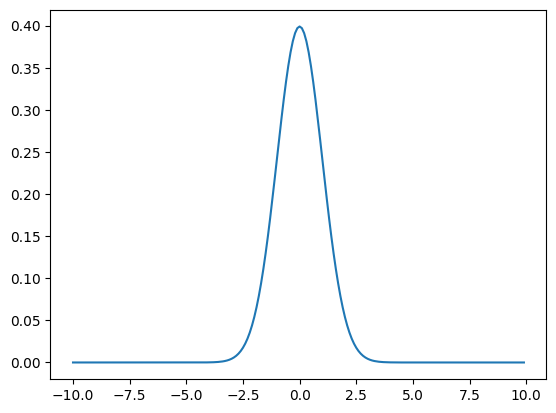

In [2]:
def loi_normale(x,mu = 0 ,sigma = 1):
    return scipy.stats.norm.pdf(x,loc = mu, scale=sigma)

x = np.arange(-10,10,0.1)
y = loi_normale(x)
plt.plot(x,y)



In [3]:
indicators = pd.read_csv("data/indicators.csv", sep = ";")


In [4]:
indicators.head()

,ID_CLIENT,BALANCE,NB_PRODUITS,CARTE_CREDIT,SALAIRE,SCORE_CREDIT,CHURN
0,15688172,0.00,2,Yes,88947.56,677.0,No
1,15787258,0.00,14,Yes,NaN,NaN,No
2,15791700,118079.47,4,Yes,143007.49,773.0,Yes
3,15569438,106702.94,2,No,198313.69,607.0,No
4,15778947,0.00,2,Yes,8742.91,628.0,No


In [5]:
df_b = indicators["BALANCE"]

In [6]:
df_b.replace(0, np.nan, inplace = True)

In [7]:
df_b.isna().sum()

3615

In [8]:
df_b.dropna(inplace = True)

In [9]:
df_b.describe()

count      6335.000000
mean     119857.355416
std       30089.774988
min        3768.690000
25%      100250.795000
50%      119912.460000
75%      139531.135000
max      250898.090000
Name: BALANCE, dtype: float64

In [10]:
df_b = df_b.sort_values()

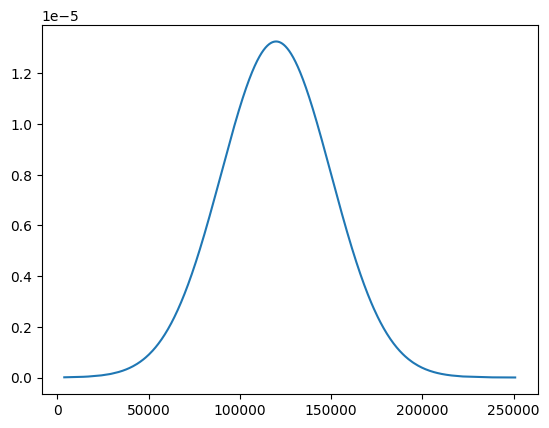

In [22]:

y = loi_normale(df_b, df_b.mean(), df_b.std())
plt.plot(df_b,y)


In [11]:
def vraisemblance(data, sigma):
    L = []
    for x in data:
        y =  loi_normale(x,mu = data.mean(), sigma = sigma)
        L.append(y)
    return np.prod(L)  

def log_vraissemblance(data, sigma):
    L = []
    for x in data:
        y =  loi_normale(x,mu = data.mean(), sigma = sigma)
        L.append(np.log(y))
    return np.sum(L)  



<AxesSubplot:>

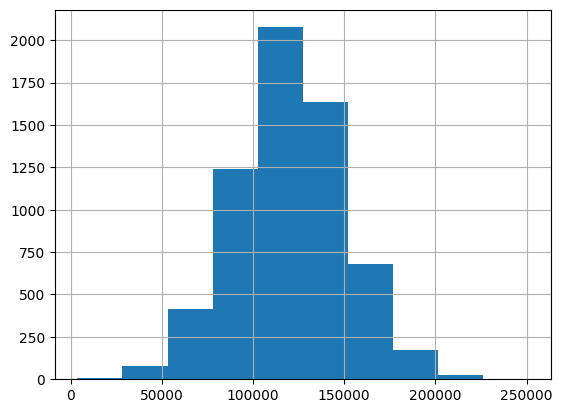

In [12]:
df_b.hist()

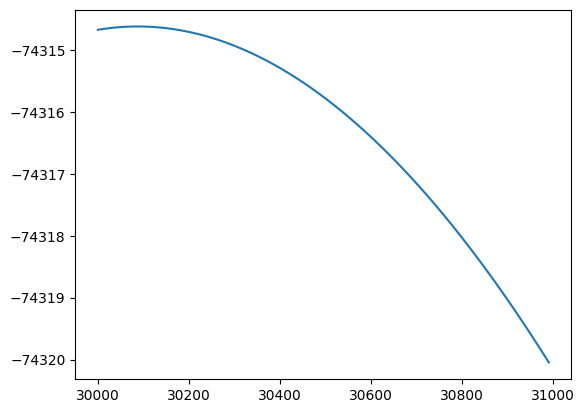

In [13]:
x = np.arange(30000,31000, 10)
y = []
for sigma in x:
    y.append(log_vraissemblance(df_b,sigma))

plt.plot(x,y)


In [14]:
df_vraisemblance =  pd.DataFrame({"x":x,"y":y})

In [15]:
df_vraisemblance

,x,y
0,30000,-74314.673566
1,30010,-74314.661954
2,30020,-74314.651759
3,30030,-74314.642980
4,30040,-74314.635614
...,...,...
95,30950,-74319.587440
96,30960,-74319.700551
97,30970,-74319.814874
98,30980,-74319.930406


In [16]:
df_vraisemblance.iloc[df_vraisemblance["y"].idxmax()] #max de vraisemblance

x    30090.000000
y   -74314.619897
Name: 9, dtype: float64

In [24]:
indicators.isna().sum()

ID_CLIENT          0
BALANCE         3615
NB_PRODUITS        0
CARTE_CREDIT       0
SALAIRE          229
SCORE_CREDIT     559
CHURN              0
dtype: int64

In [28]:
df_missing = indicators[["BALANCE","SALAIRE","SCORE_CREDIT"]]

In [26]:
df_missing.head()

,BALANCE,SALAIRE,SCORE_CREDIT
0,NaN,88947.56,677.0
1,NaN,NaN,NaN
2,118079.47,143007.49,773.0
3,106702.94,198313.69,607.0
4,NaN,8742.91,628.0


In [42]:
X = df_missing.to_numpy()

In [43]:
X

array([[      nan,  88947.56,    677.  ],
       [      nan,       nan,       nan],
       [118079.47, 143007.49,    773.  ],
       ...,
       [      nan,  22303.17,    759.  ],
       [      nan, 136610.02,    689.  ],
       [127414.55, 134459.12,    802.  ]])

In [30]:
cov_matrix = np.cov(df_missing.dropna(),rowvar=False)

In [33]:
mu_mean = df_missing.mean().to_list()

In [34]:
mu_mean

[119857.35541594317, 100043.06715461373, 650.9906293259504]

In [99]:
def impute_em(X, max_iter = 3000, eps = 1e-88):
    '''(np.array, int, number) -> {str: np.array or int}
    
    Precondition: max_iter >= 1 and eps > 0
    
    Return the dictionary with five keys where:
    - Key 'mu' stores the mean estimate of the imputed data.
    - Key 'Sigma' stores the variance estimate of the imputed data.
    - Key 'X_imputed' stores the imputed data that is mutated from X using 
      the EM algorithm.
    - Key 'C' stores the np.array that specifies the original missing entries
      of X.
    - Key 'iteration' stores the number of iteration used to compute
      'X_imputed' based on max_iter and eps specified.
    '''
    
    nr, nc = X.shape
    C = np.isnan(X) == False
    
    # Collect M_i and O_i's
    one_to_nc = np.arange(1, nc + 1, step = 1)
    M = one_to_nc * (C == False) - 1
    O = one_to_nc * C - 1
    
    # Generate Mu_0 and Sigma_0
    Mu = np.nanmean(X, axis = 0)
    observed_rows = np.where(np.isnan(sum(X.T)) == False)[0]
    S = np.cov(X[observed_rows, ].T)
    if np.isnan(S).any():
        S = np.diag(np.nanvar(X, axis = 0))
    
    # Start updating
    Mu_tilde, S_tilde = {}, {}
    X_tilde = X.copy()
    no_conv = True
    iteration = 0
    while no_conv and iteration < max_iter:
        for i in range(nr):
            S_tilde[i] = np.zeros(nc ** 2).reshape(nc, nc)
            if set(O[i, ]) != set(one_to_nc - 1): # missing component exists
                M_i, O_i = M[i, ][M[i, ] != -1], O[i, ][O[i, ] != -1]
                S_MM = S[np.ix_(M_i, M_i)]
                S_MO = S[np.ix_(M_i, O_i)]
                S_OM = S_MO.T
                S_OO = S[np.ix_(O_i, O_i)]
                Mu_tilde[i] = Mu[np.ix_(M_i)] +\
                    S_MO @ np.linalg.inv(S_OO) @\
                    (X_tilde[i, O_i] - Mu[np.ix_(O_i)])
                X_tilde[i, M_i] = Mu_tilde[i]
                S_MM_O = S_MM - S_MO @ np.linalg.inv(S_OO) @ S_OM
                S_tilde[i][np.ix_(M_i, M_i)] = S_MM_O
        Mu_new = np.mean(X_tilde, axis = 0)
        S_new = np.cov(X_tilde.T, bias = 1) +\
            reduce(np.add, S_tilde.values()) / nr
        no_conv =\
            np.linalg.norm(Mu - Mu_new) >= eps or\
            np.linalg.norm(S - S_new, ord = 2) >= eps
        Mu = Mu_new
        S = S_new
        iteration += 1
    
    result = {
        'mu': Mu,
        'Sigma': S,
        'X_imputed': X_tilde,
        'C': C,
        'iteration': iteration
    }
    
    return result

In [100]:
start = datetime.now()
result_imputed = impute_em(X)
end = datetime.now()

In [101]:
result_imputed

{'mu': array([119858.99301977, 100042.92165555,    650.98956877]),
 'Sigma': array([[ 9.05251338e+08, -5.14957851e+06, -1.71046431e+04],
        [-5.14957851e+06,  3.31237080e+09, -2.04104960e+04],
        [-1.71046431e+04, -2.04104960e+04,  9.31233076e+03]]),
 'X_imputed': array([[119828.50369198,  88947.56      ,    677.        ],
        [119858.99301977, 100042.92165555,    650.98956877],
        [118079.47      , 143007.49      ,    773.        ],
        ...,
        [119781.97122869,  22303.17      ,    759.        ],
        [119731.78230789, 136610.02      ,    689.        ],
        [127414.55      , 134459.12      ,    802.        ]]),
 'C': array([[False,  True,  True],
        [False, False, False],
        [ True,  True,  True],
        ...,
        [False,  True,  True],
        [False,  True,  True],
        [ True,  True,  True]]),
 'iteration': 36}

In [102]:
df_imputed = pd.DataFrame(result_imputed["X_imputed"])


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>, <AxesSubplot:>]], dtype=object)

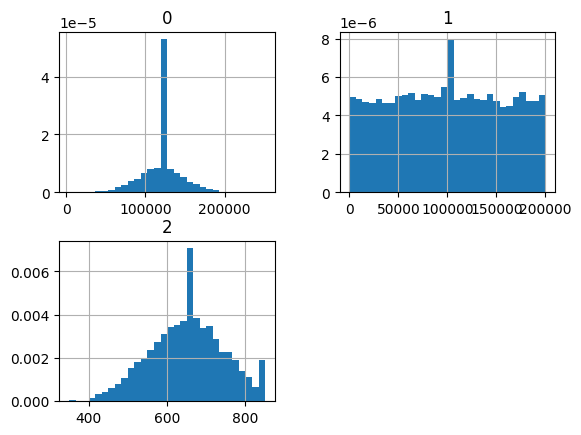

In [103]:
df_imputed.hist(density = True, bins = 30)

In [57]:
result_imputed['mu'] # estimate using the imputed data

array([119858.99301977, 100042.92165555,    650.98956877])

In [58]:
df_imputed.mean()

0    119858.993020
1    100042.921656
2       650.989569
dtype: float64